# Intro

the dataset that will be used in this notebook is the [**Mapping 2019-nCoV**](https://systems.jhu.edu/research/public-health/ncov/) which contains several datasources (including the **WHO** and the **ECDC**) and it can be found [here](https://github.com/CSSEGISandData/COVID-19)

Particually, we will use the **CSSE COVID-19 Dataset** folder, which contains two *types* of data:

- Daily reports (csse_covid_19_daily_reports): <br>
    this folder contains daily aggregated case reports, wich contains information such the number of confirmed cases, the number of deaths, and the number of recovered cases.
    each report contains accumulated till the date of the report.
    we can use the last report to show statistic measures such as total number of cases for each country, most affected countries, etc ..., but we can perform time analysis on the data.
- Time series summary (csse_covid_19_time_series):

# Import Libraries and Read Data

In [1]:
import pandas as pd
import numpy as np
import emoji

import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px

import plotly.graph_objects as go
from plotly.graph_objects import Bar
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)
plotly.offline.init_notebook_mode(connected=True)

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import squarify

sns.set()

The last report date is `04-03-2020`

In [2]:
last_report_path = 'COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/04-03-2020.csv'
world_pop_path = 'World Population Data/total_population_clean.csv'

In [3]:
df = pd.read_csv(last_report_path)
world_pop_df = pd.read_csv(world_pop_path)

# Get to know the data

In [4]:
df.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-04-03 22:46:37,34.223334,-82.461707,6,0,0,0,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-04-03 22:46:37,30.295065,-92.414197,72,1,0,0,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-04-03 22:46:37,37.767072,-75.632346,8,0,0,0,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-04-03 22:46:37,43.452658,-116.241552,307,3,0,0,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-04-03 22:46:37,41.330756,-94.471059,1,0,0,0,"Adair, Iowa, US"


In [5]:
df.shape

(2625, 12)

In [6]:
len(df['Country_Region'].unique())

181

There are 3434 reported cases across 177 countries. 

Field description
- Province/State: China - province name; US/Canada/Australia/ - city name, state/province name; Others - name of the event (e.g., "Diamond Princess" cruise ship); other countries - blank.
- Country/Region: country/region name conforming to WHO (will be updated).
- Last Update: MM/DD/YYYY HH:mm (24 hour format, in UTC).
- Confirmed: the number of confirmed cases.
- Deaths: the number of deaths.
- Recovered: the number of recovered cases.

# Data Preprocessing

In [7]:
df.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-04-03 22:46:37,34.223334,-82.461707,6,0,0,0,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-04-03 22:46:37,30.295065,-92.414197,72,1,0,0,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-04-03 22:46:37,37.767072,-75.632346,8,0,0,0,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-04-03 22:46:37,43.452658,-116.241552,307,3,0,0,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-04-03 22:46:37,41.330756,-94.471059,1,0,0,0,"Adair, Iowa, US"


## 1 - Drop irrelevant columns:

`FIPS`: the **FIPS** represents the Federal Information Processing Standard state code, and it's related only to the `U.S.` states, we won't need it now (unless we want to draw a map specific to the `U.S.`)

`Admin2`: it's not clear what does this column means, will be dropped :)

`Province_State`: the city on which the case was recorded, but not all cases are associated with the city, so we will drop it.

In [8]:
df['Province_State'].isna().sum()

177

`Last_update`: the date on which this row was last updated, irrelvant to our analysis.

`Lat` and `Long_` columns specify the coordinates of the case, we won't be needing this inofrmation right now.

`Combined_Key`: this column is the concatenation of `Admin2`, `Province_State`, and ` 	Country_Region`, irrelvant too.

In [9]:
def drop_irrelevant_columns(df, irrelevant_columns):
    new_df = df.drop(columns=irrelevant_columns)
    return new_df

In [10]:
irrelevant_columns = ['FIPS', 'Admin2', 'Province_State', 'Last_Update', 'Lat', 'Long_', 'Combined_Key']

In [11]:
df = drop_irrelevant_columns(df, irrelevant_columns)

In [12]:
df.head()

,Country_Region,Confirmed,Deaths,Recovered,Active
0,US,6,0,0,0
1,US,72,1,0,0
2,US,8,0,0,0
3,US,307,3,0,0
4,US,1,0,0,0


## 2 - Normalize columns' names:

rename column `Country_Region` to `Country`, for easier manipulation

In [13]:
def rename_columns(df, columns_mapping):
    new_df = df.rename(columns=columns_mapping)
    return new_df

In [14]:
columns_mapping = {
    'Country_Region': 'Country'
}

In [15]:
df = rename_columns(df, columns_mapping)

In [16]:
df.head()

,Country,Confirmed,Deaths,Recovered,Active
0,US,6,0,0,0
1,US,72,1,0,0
2,US,8,0,0,0
3,US,307,3,0,0
4,US,1,0,0,0


## 3 - Aggregate data by countries:
aggregate the number of confirmed cases, number of deaths, number of reovered cases, and number of active cases for each country.

In [17]:
def apply_aggregation(df, group_by_column, sort_by_column):
    aggregate_df = df.groupby(by=group_by_column)\
                        .sum()\
                        .reset_index()\
                        .sort_values(by=sort_by_column, ascending=False)
    return aggregate_df

In [18]:
aggregated_df = apply_aggregation(df, group_by_column='Country', sort_by_column='Deaths')

In [19]:
aggregated_df.head(10)

,Country,Confirmed,Deaths,Recovered,Active
84,Italy,119827,14681,19758,85388
154,Spain,119199,11198,30513,77488
169,US,275586,7087,9707,0
61,France,65202,6520,14135,44547
173,United Kingdom,38689,3611,208,34870
36,China,82511,3326,76760,2425
80,Iran,53183,3294,17935,31954
120,Netherlands,15821,1490,260,14071
65,Germany,91159,1275,24575,65309
16,Belgium,16770,1143,2872,12755


the number of `Confirmed` cases in each country should be equal to the sum of: `Deaths`, `Recovered`, and `Active`

In [20]:
aggregated_df['Confirmed'].eq(aggregated_df['Deaths'] + aggregated_df['Recovered'] + aggregated_df['Active']).sum()

179

In [21]:
aggregated_df.shape

(181, 5)

there are two countries, for which the condition doesn't hold, let's find them:

In [22]:
aggregated_df[aggregated_df['Confirmed'] != aggregated_df['Deaths'] + aggregated_df['Recovered'] + aggregated_df['Active']]

,Country,Confirmed,Deaths,Recovered,Active
169,US,275586,7087,9707,0
32,Canada,12437,179,2175,0


<p style="font-size:200%;">🤔</p>

only the `U.S.` and `Canada` has no active cases.

## 4 - Focus on *Outbreaks*:
We will focus in this notebook only on countries with high **death tolls**, countires that are *nearly* affected by the pandemic will be discarded.

In [23]:
most_affected_countries_names = aggregated_df['Country'][:10].values

In [24]:
print(most_affected_countries_names)

['Italy' 'Spain' 'US' 'France' 'United Kingdom' 'China' 'Iran'
 'Netherlands' 'Germany' 'Belgium']


In [25]:
most_affected_df = aggregated_df[aggregated_df['Country'].isin(most_affected_countries_names)]

In [26]:
most_affected_df.head()

,Country,Confirmed,Deaths,Recovered,Active
84,Italy,119827,14681,19758,85388
154,Spain,119199,11198,30513,77488
169,US,275586,7087,9707,0
61,France,65202,6520,14135,44547
173,United Kingdom,38689,3611,208,34870


# Data Visualization

## Pie Chart

In [27]:
fig = px.pie(most_affected_df, names='Country', values='Deaths',
             color='Deaths', color_discrete_sequence=px.colors.sequential.Blues_r)
fig.show()

## Treemap Chart

In [46]:
reds = sns.color_palette('Reds', 10)

In [47]:
reds.reverse()

In [48]:
reds.as_hex()

['#940b13',
 '#b61319',
 '#d11e1f',
 '#ec382b',
 '#f7593f',
 '#fb7858',
 '#fc9576',
 '#fcb499',
 '#fdd0bc',
 '#fee6da']

In [28]:
fig = px.treemap(most_affected_df, path=['Country'], values='Deaths')
fig.show()

## Stacked Bar Chart:

In [29]:
fig = go.Figure(data=[
    go.Bar(name='Deaths', x=most_affected_df['Country'], y=most_affected_df['Deaths']),
    go.Bar(name='Recovered', x=most_affected_df['Country'], y=most_affected_df['Recovered']),
    go.Bar(name='Active', x=most_affected_df['Country'], y=most_affected_df['Active']),
])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

## Horizontal Stacked Bar Chart

In [30]:
fig = go.Figure(data=[
    go.Bar(name='Deaths', x=most_affected_df['Deaths'], y=most_affected_df['Country'], orientation='h'),
    go.Bar(name='Recovered', x=most_affected_df['Recovered'], y=most_affected_df['Country'], orientation='h'),
    go.Bar(name='Active', x=most_affected_df['Active'], y=most_affected_df['Country'], orientation='h')
])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

## Countries fatalities rate:

In [31]:
countries_fatalities_df = pd.DataFrame(data=most_affected_df[['Country', 'Confirmed', 'Deaths']])

In [32]:
countries_fatalities_df.sort_values(by='Confirmed', ascending=False, inplace=True)

In [33]:
countries_fatalities_df.head()

,Country,Confirmed,Deaths
169,US,275586,7087
84,Italy,119827,14681
154,Spain,119199,11198
65,Germany,91159,1275
36,China,82511,3326


let's compute the fatality rate:

The fatalit rate of a country, is: (deaths * 100) / confirmed

In [34]:
countries_fatalities_df['fatality rate'] = (countries_fatalities_df['Deaths'] * 100) / countries_fatalities_df['Confirmed']

In [35]:
countries_fatalities_df

,Country,Confirmed,Deaths,fatality rate
169,US,275586,7087,2.571611
84,Italy,119827,14681,12.251830
154,Spain,119199,11198,9.394374
65,Germany,91159,1275,1.398655
36,China,82511,3326,4.030978
61,France,65202,6520,9.999693
80,Iran,53183,3294,6.193709
173,United Kingdom,38689,3611,9.333402
16,Belgium,16770,1143,6.815742
120,Netherlands,15821,1490,9.417862


**Italy** has the highest fatality rate, while **Germany** has the lowest one.

The fatality rate is effected by both factors:
- The quality of health care.
- The average age of the population.

In [36]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(
    go.Bar(name='Confirmed', x=countries_fatalities_df['Confirmed'], y=countries_fatalities_df['Country'], orientation='h'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(name='Deaths', x=countries_fatalities_df['Deaths'], y=countries_fatalities_df['Country'], orientation='h'),
    row=1, col=2
)

fig.add_trace(
    go.Bar(name='fatality rate', x=countries_fatalities_df['fatality rate'], y=countries_fatalities_df['Country'], orientation='h'),
    row=1, col=3
)

fig.show()

## Cases per million people:

In [37]:
cases_statistics_df = most_affected_df.merge(world_pop_df, left_on='Country', right_on='Country Name', how='inner')

In [38]:
cases_statistics_df.head()

,Country,Confirmed,Deaths,Recovered,Active,Country Name,Country Code,population size
0,Italy,119827,14681,19758,85388,Italy,ITA,60431283.0
1,Spain,119199,11198,30513,77488,Spain,ESP,46723749.0
2,US,275586,7087,9707,0,US,USA,327167434.0
3,France,65202,6520,14135,44547,France,FRA,66987244.0
4,United Kingdom,38689,3611,208,34870,United Kingdom,GBR,66488991.0


In [39]:
cases_statistics_df['cases per million'] = (1000000.0 * cases_statistics_df['Confirmed']) / cases_statistics_df['population size']
cases_statistics_df['deaths per million'] = (1000000.0 * cases_statistics_df['Deaths']) / cases_statistics_df['population size']

In [40]:
cases_statistics_df

,Country,Confirmed,Deaths,Recovered,Active,Country Name,Country Code,population size,cases per million,deaths per million
0,Italy,119827,14681,19758,85388,Italy,ITA,6.043128e+07,1982.863743,242.937089
1,Spain,119199,11198,30513,77488,Spain,ESP,4.672375e+07,2551.143745,239.663988
2,US,275586,7087,9707,0,US,USA,3.271674e+08,842.339339,21.661691
3,France,65202,6520,14135,44547,France,FRA,6.698724e+07,973.349493,97.331964
4,United Kingdom,38689,3611,208,34870,United Kingdom,GBR,6.648899e+07,581.885804,54.309743
5,China,82511,3326,76760,2425,China,CHN,1.392730e+09,59.244075,2.388115
6,Iran,53183,3294,17935,31954,Iran,IRN,8.180027e+07,650.156786,40.268816
7,Netherlands,15821,1490,260,14071,Netherlands,NLD,1.723102e+07,918.169833,86.471971
8,Germany,91159,1275,24575,65309,Germany,DEU,8.292792e+07,1099.255809,15.374797
9,Belgium,16770,1143,2872,12755,Belgium,BEL,1.142207e+07,1468.210485,100.069445


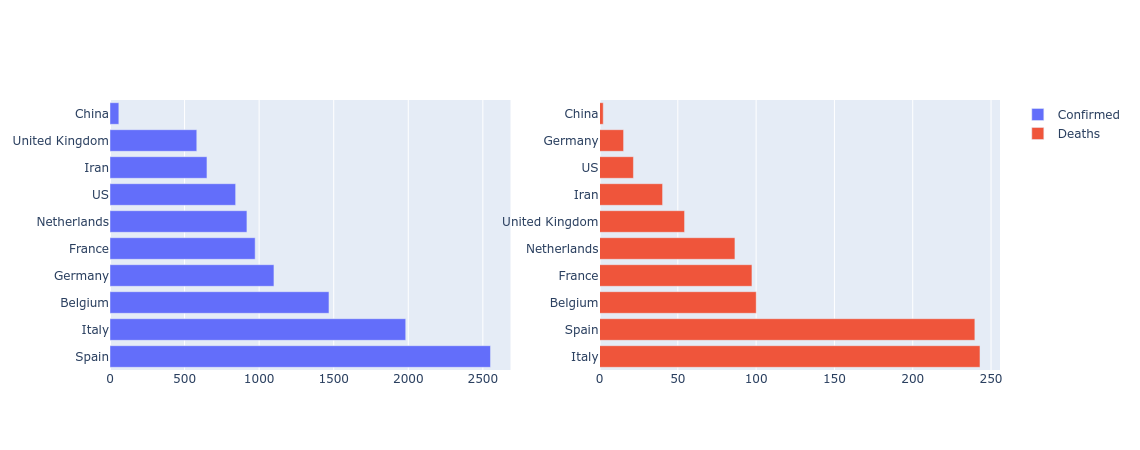

In [41]:
fig = make_subplots(rows=1, cols=2)

# sort data by `cases per million` column

cases_statistics_df.sort_values(by='cases per million', ascending=False, inplace=True)

fig.add_trace(
    go.Bar(name='Confirmed', x=cases_statistics_df['cases per million'], y=cases_statistics_df['Country'], orientation='h'),
    row=1, col=1
)

# sort data by `deaths per million` column

cases_statistics_df.sort_values(by='deaths per million', ascending=False, inplace=True)

fig.add_trace(
    go.Bar(name='Deaths', x=cases_statistics_df['deaths per million'], y=cases_statistics_df['Country'], orientation='h'),
    row=1, col=2
)

fig.show()

In [42]:
fig.write_html(file='cases_per_million_people.html', include_plotlyjs='cdn')